In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1
import time

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

# Determine number of "events" that happen per year, and then establish your return period of interest

In [2]:
return_period = 200 # in years
#events_per_year = 151-40
events_per_year = 151/40

#return_period = 100
#events_per_year = 1

return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

99.86754966887416


In [3]:
working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'
#save_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calculations/npy_files/'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [4]:
working_dir = '/Users/baird/google_drive/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/'
#threshold=0.0
threshold=0.1
#threshold=0.5
#threshold=1.0
#threshold=5.0
#threshold=10.0

In [5]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

# Open preindustrial control data

In [6]:
year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

# create season strings
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)
#season_strings_pic = numpy.empty(years.size-1, dtype=numpy.str)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_pic=year_end_pic-year_start_pic

Steps:

1.  Import all data for PIC (at each grid point, you should have 1798 years of storm magnitude lists)
2.  At each grid point, pool all of these data together
3.  At each grid point, calculate the 99th percentile and COUNT THE NUMBER OF STORMS LARGER THAN THIS
4.  Store this number and also calculate a "events per season" number by dividing by number of years

Then when doing end-of-century stuff:

1.  Import all data for hist and RCP 8.5 for a 30-year chunk (at each grid point, you'll have 40$\times$30 years of data)
2.  Then for each grid point, calculate the number of times the 99th percentile in PIC was exceeded in hist/RCP
3.  Sum the number of exceedences, divide by (normalize by) the number of years (in this case, 30$\times$40)
4.  Take this value and divide it by the PIC value.

In [7]:
return_period_values_pic_df = pandas.read_csv('csv_files/return_period_values_pic_df_update.csv')
#return_period_values_pic_df = pandas.read_csv('csv_files/return_period_values_pic_df.csv')
return_period_values_pic = return_period_values_pic_df.values[:,1:]

In [8]:
print(return_period_values_pic)

[[ 362.19780582  267.        ]
 [ 336.0775977   267.        ]
 [ 328.76205885  267.        ]
 ..., 
 [  85.29207875  267.        ]
 [ 100.13625505  267.        ]
 [  88.1828632   267.        ]]


# Open historical and RCP8.5 data

In [9]:
year_start = 2070
year_end = 2100

year_start_list = [1920,1950,1980,2010,2040,2070]
year_end_list = [1950,1980,2010,2040,2070,2100]

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)

season_strings_hist_rcp = [str(years[i])+'-'+str(years[i+1]) for i in range(years.size-1)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

In [10]:
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

# Also save as npy file

In [11]:
all_events_hist_rcp = numpy.load('csv_files/all_events_hist_rcp_npy.npy')

# Load data as csv file

all_events_hist_rcp_df = pandas.read_csv('csv_files/all_events_hist_rcp_df.csv')
all_events_hist_rcp = all_events_hist_rcp_df.values[:,1:]

In [12]:
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'
# for each grid point:
# cycle through all times, get extreme seasonal sum in each time period, store in array with length(season_strings_pic)
# once this is done, calculate the return periods of each of these
return_period_values_hist_rcp = numpy.zeros(( PRECT_nlat*PRECT_nlon, 3 ))

for latlon_idx in range(len(latlon_indices)):
    all_events = all_events_hist_rcp[latlon_idx,:]
    return_period_values_hist_rcp[latlon_idx,0] = numpy.nanpercentile(all_events, return_val_perc)
    return_period_values_hist_rcp[latlon_idx,1] = numpy.nansum(all_events>return_period_values_hist_rcp[latlon_idx,0])
    return_period_values_hist_rcp[latlon_idx,2] = numpy.nansum(all_events>return_period_values_pic[latlon_idx,0])
return_period_values_hist_rcp_df = pandas.DataFrame(return_period_values_hist_rcp, columns=['Perc value hist eoc','Num hist eoc exceedances','Num PIC exceedances'])
csv_filename = 'return_period_values_hist_rcp_dataframe_'+str(year_start)+'-'+str(year_end)+'.csv'
return_period_values_hist_rcp_df.to_csv('csv_files/'+csv_filename)
print(csv_filename, 'written!')

return_period_values_hist_rcp_dataframe_2070-2100.csv written!


In [13]:
print(return_val_perc)

99.86754966887416


In [14]:
return_period_values_hist_rcp_df = pandas.read_csv('csv_files/return_period_values_hist_rcp_dataframe_'+str(year_start)+'-'+str(year_end)+'.csv')
return_period_values_hist_rcp = return_period_values_hist_rcp_df.values[:,1:]

In [15]:
pic_counts = return_period_values_pic[:,1]
hist_rcp_counts = return_period_values_hist_rcp[:,2]

# Plot return values for PIC

In [16]:
return_values_pic_2d = return_period_values_pic[:,0].reshape(PRECT_nlat, PRECT_nlon)

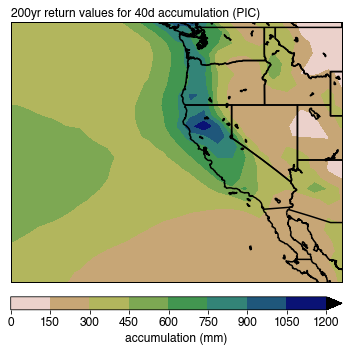

In [17]:
fontsize=12
contour_levels = numpy.arange(0,1201,150)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, return_values_pic_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('accumulation (mm)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)

ax.text(s='200yr return values for 40d accumulation (PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('200yr_return_values_40d_accumulation_PIC.pdf', transparent=True, bbox_inches='tight')

# Plot hist and RCP map

In [18]:
return_values_hist_rcp_2d = return_period_values_hist_rcp[:,0].reshape(PRECT_nlat, PRECT_nlon)

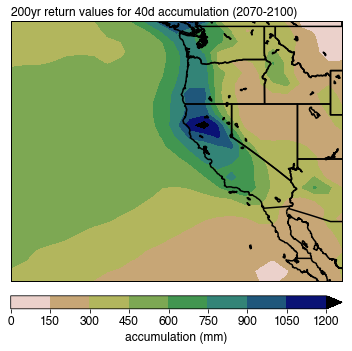

In [19]:
fontsize=12
contour_levels = numpy.arange(0,1201,150)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, return_values_hist_rcp_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('accumulation (mm)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)

ax.text(s='200yr return values for 40d accumulation (2070-2100)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('200yr_return_values_40d_accumulation_2070-2100.pdf', transparent=True, bbox_inches='tight')

# Plot relative change in PIC 200yr return interval exceedances

In [28]:
print(pic_counts)

[ 267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  266.
  266.  264.  267.  265.  266.  267.  255.  267.  267.  267.  266.  262.
  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.
  267.  267.  267.  267.  267.  266.  267.  267.  267.  267.  267.  256.
  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.
  267.  267.  267.  267.  267.  267.  266.  267.  267.  267.  267.  265.
  265.  267.  266.  267.  267.  267.  267.  267.  267.  267.  267.  267.
  267.  267.  267.  267.  267.  266.  267.  267.  267.  267.  267.  266.
  267.  266.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.
  267.  267.  267.  267.  266.  267.  267.  267.  267.  267.  267.  267.
  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.
  267.  267.  267.  267.  267.  267.  267.  267.  266.  267.  267.  267.
  267.  266.  267.  267.  267.  267.  267.  267.  267.  267.  267.  267.
  267.  267.  267.  267.  267.  267.  267.  267.  2

In [20]:
count_ratio = (hist_rcp_counts/(30*40))/(pic_counts/1798)
count_ratio_2d = count_ratio.reshape((PRECT_nlat, PRECT_nlon))

In [21]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [22]:
# make color map
minval=0.0 # 
maxval=0.85 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

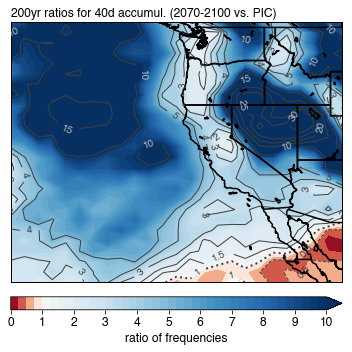

In [23]:
fontsize=12
contour_levels = numpy.arange(0,10.01,0.25)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

#pr_map = map.contourf(xi, yi, count_ratio_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

pr_map = map.contourf(xi, yi, count_ratio_2d, \
                      #cmap='inferno', \
                      cmap='RdBu', \
                      norm=MidpointNormalize(midpoint=1.0), \
                      levels=contour_levels, \
                      zorder=2, \
                      extend='max', \
                      latlon=True)
contour_plot = pr_contour = map.contour(xi, yi, count_ratio_2d, \
                         levels=[0.5,1.,1.5,2,3,4,5.,10.,15.,20.,25.,30.], \
                         colors='0.25', \
                         linewidths=[1]*1+[2]+[1]*10, \
                         linestyles=['--']*1+[':']+['-']*10, \
                         )

new_levels = []
for i in contour_plot.levels:
    if i in [0.5,1.5]:
        new_levels.append('{:.1f}'.format(i))
    else:
        new_levels.append('{:.0f}'.format(i))
contour_plot.levels = new_levels
mp.clabel(contour_plot, fontsize=fontsize-2, colors=['0.25']*7+['0.75']*5)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('ratio of frequencies', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)
cbar.set_ticks([0,1,2,3,4,5,6,7,8,9,10])

ax.text(s='200yr ratios for 40d accumul. (2070-2100 vs. PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('200yr_return_values_40d_accumulation_RATIOS.pdf', transparent=True, bbox_inches='tight')

# Now plot the fraction of the magnitudes of the Nth percentile

In [24]:
return_period_value_ratios_2d = return_values_hist_rcp_2d/return_values_pic_2d

/Users/baird/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


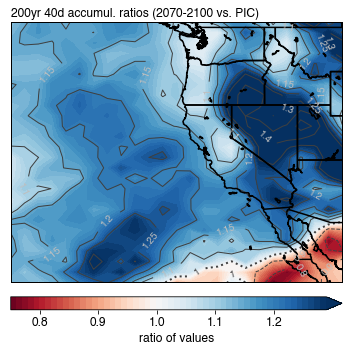

In [25]:
fontsize=12
contour_levels = numpy.arange(0.75,1.3,0.01)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

#pr_map = map.contourf(xi, yi, count_ratio_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

pr_map = map.contourf(xi, yi, return_period_value_ratios_2d, \
                      #cmap='inferno', \
                      cmap='RdBu', \
                      norm=MidpointNormalize(midpoint=1.0), \
                      levels=contour_levels, \
                      zorder=2, \
                      extend='max', \
                      latlon=True)
contour_plot = pr_contour = map.contour(xi, yi, return_period_value_ratios_2d, \
                         levels=[0.8,0.9,1,1.1,1.15,1.2,1.25,1.3,1.4,1.5], \
                         colors='0.25', \
                         linewidths=[1]*2+[2]+[1]*7, \
                         linestyles=['--']*2+[':']+['-']*7, \
                         )

new_levels = []
for i in contour_plot.levels:
    if i in [1]:
        new_levels.append('{:.0f}'.format(i))
    elif i in [1.15,1.25]:
        new_levels.append('{:.2f}'.format(i))
    else:
        new_levels.append('{:.1f}'.format(i))
contour_plot.levels = new_levels
mp.clabel(contour_plot, fontsize=fontsize-2, colors=['0.75']*2+['0.25']+['0.75']*7)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('ratio of values', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)
cbar.set_ticks(numpy.arange(0.8,1.31,0.1))

ax.text(s='200yr 40d accumul. ratios (2070-2100 vs. PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('200yr_40d_accumulation_RATIOS_of_magnitudes.pdf', transparent=True, bbox_inches='tight')

In [26]:
# save hist clim
filename = '200yr_40d_wet_accumulations.nc'

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat.size)
lon_dim = ncfile.createDimension('lon', PRECT_lon.size)

lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lat_var[:] = PRECT_lat
lon_var[:] = PRECT_lon
lat_var.units = 'degrees_north'
lon_var.units = 'degrees_east'

return_values_pic = ncfile.createVariable('return_values_pic', 'f4', ('lat','lon'))
return_values_pic[:] = return_values_pic_2d
return_values_pic.units = 'mm'
return_values_pic.description = '200yr 40d accumulation return values calculated during PIC runs'

return_values_eoc = ncfile.createVariable('return_values_eoc', 'f4', ('lat','lon'))
return_values_eoc[:] = return_values_hist_rcp_2d
return_values_eoc.units = 'mm'
return_values_eoc.description = '200yr 40d accumulation return values calculated during RCP8.5 runs (2070-2100)'

ratios_of_values = ncfile.createVariable('ratios_of_values', 'f4', ('lat','lon'))
ratios_of_values[:] = return_period_value_ratios_2d
ratios_of_values.units = 'unitless'
ratios_of_values.description = 'Ratios of 200yr return values (2070-2100 vs. PIC)'

ratios_of_frequencies = ncfile.createVariable('ratios_of_frequencies', 'f4', ('lat','lon'))
ratios_of_frequencies[:] = count_ratio_2d
ratios_of_frequencies.units = 'unitless'
ratios_of_frequencies.description = 'Ratios of 200yr return value exceedance frequencies (2070-2100 vs. PIC)'

ncfile.history = 'Created ' + time.ctime(time.time())
ncfile.close()
print(filename, "saved")

200yr_40d_wet_accumulations.nc saved
